# Title : predicting protein solubility 

# Contents
### 1.	Data set information
### 2.	Data cleaning
### 3.	Feature engineering
### 4.	Model selection and training 
### 5.	Model evaluation
### 6.	Model tuning
### 7.	Conclusions and discussions
### 8.	Future work



In [17]:
import os
import json
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from scipy.stats import spearmanr
from sklearn.model_selection import (train_test_split,cross_validate,learning_curve)
from sklearn.model_selection import (KFold,GridSearchCV)
from sklearn.preprocessing import (StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer,PowerTransformer)
from sklearn.metrics import (mean_squared_error,mean_absolute_error,r2_score,make_scorer)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import (LinearRegression,Ridge,Lasso,ElasticNet)
from sklearn.ensemble import (RandomForestRegressor,GradientBoostingRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


# 1. DATASET CLEANING and Feature engineering

The dataset was taken from 

Title : predicting protein solubility 

data set used: eSOL: Solubility data for Ecoli proteins

    DOI: [10.18908/lsdba.nbdc00440-001](https://dbarchive.biosciencedbc.jp/en/esol/data-1.html)


In [18]:
dataset_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Dataset"
log_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\logs"
img_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\Protein_Solubility_ML_Model\Figuredump"
other_dir = r"Q:\coding_dir\Rep_dir\VScode_Lib\testersession\porj\SPC707P\labs\Week12\loos_dir"
d1 = pd.read_csv(os.path.join(dataset_dir, "esol.csv"))
print(d1.shape)

(4132, 28)


##### Initial dataset composition

(4132, 28)
Index(

       ['JW_ID', 'ECK number', 'B number', 'Gene name K-12', 'Locus name K-12','Synonyms of locus names K-12', 'Solubility (%)', 'Yield (uM)',

       'Yield (ug/ml)', 'Minus Sol (%)', 'TF Sol (%)', 'GroE Sol (%)','KJE Sol (%)', 'Minus Yield (uM)', 'TF Yield (uM)', 'GroE Yield (uM)',

       'KJE Yield (uM)', 'Minus Yield (ug/ml)', 'TF Yield (ug/ml)','GroE Yield (ug/ml)', 'KJE Yield (ug/ml)', 'Calculated MW (kDa)',

       'Calculated pI', 'Type of gene product', 'Gene product description','Cell location', 'Structure (PDB) ID', 'SCOP assignment'],

      dtype='object')


Okay first things first lets try and identify the dimensions that confer with solubility.

The Solubility (%) will be our lable(y), so this dimension must be complete(No NANs).
"Calculated MW (kDa)", "Calculated pI" these are features that will have direct impact on the solubility i think. We should use this.
biologically speeking, Yeild data('Yield (uM)','Yield (ug/ml)') will have some correlation with solubility but this may result in high correlation issues.
'Type of gene product', 'Cell location' These features may have some critical instance class bias as some classes of proteins may be less expressable(less soluble). These dimenisons will be saved and potentially used for later evaluation.

In [19]:
lable = "Solubility (%)"
crit_col = ["Calculated MW (kDa)", "Calculated pI"]
adicols = ["Yield (uM)", "Yield (ug/ml)"]
assaycols = ["JW_ID","Solubility (%)","Calculated MW (kDa)", "Calculated pI","Yield (uM)", "Yield (ug/ml)"]
optional_cols = ["Type of gene product", "Cell location"] 

array([[<Axes: title={'center': 'Solubility (%)'}>,
        <Axes: title={'center': 'Calculated MW (kDa)'}>],
       [<Axes: title={'center': 'Calculated pI'}>,
        <Axes: title={'center': 'Yield (uM)'}>],
       [<Axes: title={'center': 'Yield (ug/ml)'}>, <Axes: >]],
      dtype=object)

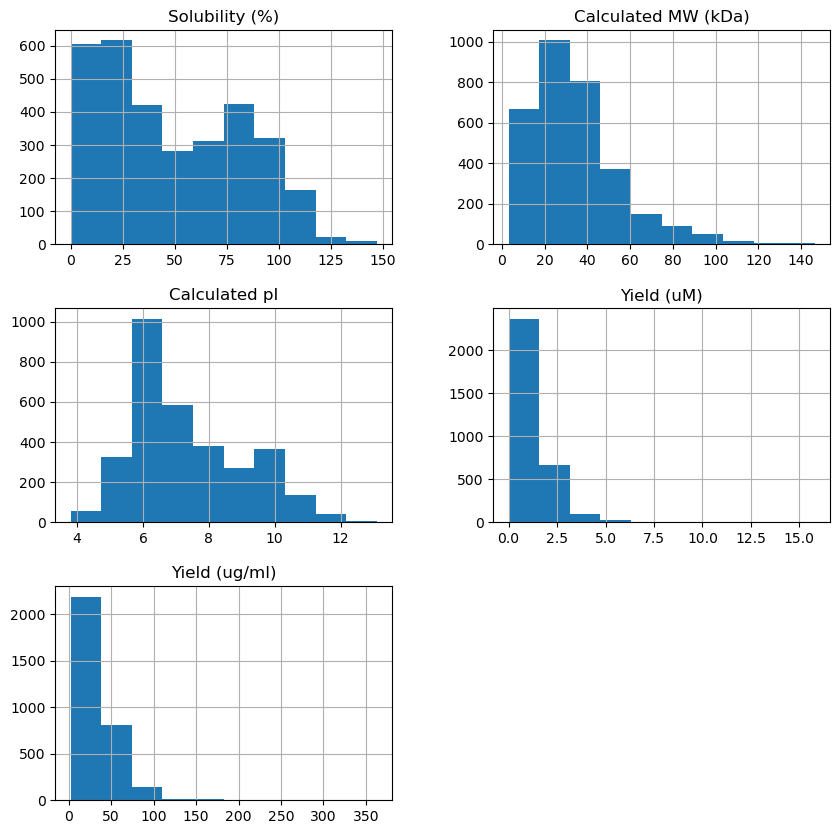

In [20]:
# first we need the lable.. so 
cdf = d1.dropna(subset=lable).copy()            #complete lable df shape: (3173, 28)
# next need to check for critical column integrity
# print(cdf[crit_col].isna().sum())               # no missing vals
# print(cdf[adicols].isna().sum())                # no missing vals
# final clean shape = 3173,28

assaydf = cdf[assaycols].copy()                 #(3173, 5)
assaydf.describe()
assaydf.hist(figsize=(10, 10))


### completing the data set

For evaluation of biological data, especially proteins, we require the protein sequence for full analysis. In this case, the E. coli Esol dataset includes the description of the E. coli gene, but no FASTA or DNA sequence was included. There are several ways of fetching the protein sequence for the instances, but since I have previous experience in fetching this type of data from [Uniprot](https://www.uniprot.org/), we will be using Uniport for this. 



From manually searching some of the instance data, thankfully, the dimension jw_id matches a single entry on the DB, so we will diesect the back end data sheet of the search result to identify the key for extracting the protein sequecne.

In [21]:
Targ_ULR = "https://rest.uniprot.org/uniprotkb/search"
params = {
    "query": "JW2231",
    "format": "json",   # full JSON
}

response = requests.get(Targ_ULR, params=params)
print("Status:", response.status_code)

data = response.json()
with open(os.path.join(other_dir, "UNIPROTfetchJson.json"), "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)

Status: 200


            "sequence": {
                "value": "MAVSAKYDEFNHWWATEGDWVEEPNYRRNGMSGVQCVERNGKKLYVKRMTHHLFHSVRYPFGRPTIVREVAVIKELERAGVIVPKIVFGEAVKIEGEWRALLVTEDMAGFISIADWYAQHAVSPYSDEVRQAMLKAVALAFKKMHSINRQHGCCYVRHIYVKTEGNAEAGFLDLEKSRRRLRRDKAINHDFRQLEKYLEPIPKADWEQVKAYYYAM",
                "length": 216,
                "molWeight": 25296,
                "crc64": "49B8E72F553113FD",
                "md5": "B5EC566BFBE36672B78744D86C0B9E27"
            },
This is the part that we are interested in. 
 Now lets just extract this bit section

In [ ]:
def fetch_uniprot_seq_by_jw(jw_id):
    if pd.isna(jw_id):
        return None, "JW_ID is NaN"

    query = f"{jw_id} AND organism_id:83333"            #for Ecoli12
    
    params = {"query": query,"fields": "accession,id,gene_names,organism_id,sequence",
              "format": "tsv","size": 5}
    try:
        r = requests.get(Targ_ULR, params=params)
        if r.status_code != 200:
            return None, f"HTTP {r.status_code}: {r.text[:200]}"

        text = r.text.strip()
        if not text:
            return None, "Empty response"

        lines = text.splitlines()
        if len(lines) <= 1:
            return None, "No hits"

        header = lines[0].split("\t")
        if "Sequence" not in header:
            return None, f"'Sequence' column missing. Header={header}"

        seq_idx = header.index("Sequence")
        first = lines[1].split("\t")
        seq = first[seq_idx]

        if seq == "":
            return None, "Empty sequence"

        return seq, None
    except Exception as e:
        return None, f"Exception: {str(e)}"
    
def add_sequences_with_progress(indf,id_col="JW_ID",sleep_sec=0.1,writemode="ON",dropmode="ON"):
    df = indf.copy()
    df["UniProt_seq"] = None
    unique_ids = df[id_col].dropna().unique()
    total = len(unique_ids)

    id_to_seq = {}
    error_log = []

    for i, jw in enumerate(unique_ids, start=1):
        seq, err = fetch_uniprot_seq_by_jw(jw)
        if err is None:
            id_to_seq[jw] = seq
            print(f"[{i}/{total}] {jw}: OK")
        else:
            id_to_seq[jw] = None
            print(f"[{i}/{total}] {jw}: FAIL → {err}")
            error_log.append({id_col: jw, "Error": err})
        time.sleep(sleep_sec)

    seq_df = pd.DataFrame([{id_col: jw, "UniProt_seq": id_to_seq.get(jw)}for jw in unique_ids])
    # dict for loop in pd.DATAFRAME to contsruct...
    #logging er
    err_df = pd.DataFrame(error_log)
    wmode = str(writemode).upper()
    dmode = str(dropmode).upper()

    # setting mode
    if wmode == "ON":
        df["UniProt_seq"] = df[id_col].map(id_to_seq)

        if dmode == "ON":
            df = df.dropna(subset=["UniProt_seq"]).copy()
        main_df = df
    else:
        main_df = seq_df
    return main_df, seq_df, id_to_seq, err_df


In [98]:
# assaydf_seq, seq_map_df, id_to_seq, err_df = add_sequences_with_progress(assaydf,id_col="JW_ID",writemode="ON",dropmode="ON")
print("DONE!")

DONE!


In [ ]:
# assaydf_seq.to_csv(os.path.join(dataset_dir, "esolc_with_sequences.csv"), index=False)
# seq_map_df.to_csv(os.path.join(dataset_dir, "seq-jwidmap.csv"), index=False)
# err_df.to_csv(os.path.join(log_dir, "uniprot_sequence_errors.csv"), index=False)
assaydf_seq = pd.read_csv(os.path.join(dataset_dir,"esolc_with_sequences.csv"))

##### final dataset after cleaning : assaydf_seq

# Sequence-based Feature Engineering
Since only a limited number of dimensions was extracted from the original dataset, here we engineered a comprehensive set of sequence-based descriptors to capture intrinsic biochemical properties influencing protein solubility.

The basic sequence composition were primarily derived directly from the amino acid sequences. Which includes sequence length, fractional composition of all 20 amino acids, and residue-group fractions representing charge, polarity, hydrophobicity, aromaticity and turn-forming propensity. These were complemented with extended physicochemical indices such as GRAVY, aliphatic index, aromaticity, instability index, and net charge at pH 7.

As a result, in combination of the original dataset dimensions, we were left with a total of 38 dimensions that covers most off the sequence level biochemical representation to global physiological characterisation. 

##### Basic features
- Length
- 20 AA fractional composition
- Residue group fractions
- frac_pos = (K+R+H)/L
- frac_neg = (D+E)/L
- frac_charged = (K+R+H+D+E)/L
- frac_polar = (S+T+N+Q+Y+C)/L
- frac_hydrophobic = (A+V+L+I+M+F+W+Y)/L
- frac_aromatic = (F+W+Y)/L
- frac_turn = (N+G+P+S)/L

##### Extended features
- GRAVY
- Aliphatic index
- Aromaticity index
- Instability index
- Net charge at pH 7

##### some additonal information about [GRAVY](https://peptidechemistry.org/gravy-score-in-peptides/)
The gravy is a scoreing system representing the hydrophathy acroos the residues exhibited in the rpotein sequence.

defined by the formaula $GRAVY=1/n∑_i^nH_i$ where $H_i$ = hydropathy index of residue i (Kyte-Doolittle value)


In [ ]:
# Parameters
AA20 = list("ACDEFGHIKLMNPQRSTVWY")
# Kyte–Doolittle hydropathy index (for GRAVY)
KD = {"A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3}
# pKa values for net charge at pH 7 (very standard approximations)
PKA_N_TERM = 9.6
PKA_C_TERM = 2.4
PKA_SIDE = {"D": 4.0,"E": 4.4,"H": 6.5,"C": 8.5,
            "Y": 10.0,"K": 10.5,"R": 12.5,}

vdw_radii = {"H": 1.20,"C": 1.70,"N": 1.55,"O": 1.52,"F": 1.47,
    "P": 1.80,"S": 1.80,"Cl": 1.75,"Br": 1.85,"I": 1.98,"B": 1.92,
    "Si": 2.10,"Se": 1.90,"Zn": 1.39,"Cu": 1.40,"Fe": 1.32,"Mg": 1.73,
    "Na": 2.27,"K": 2.75,"Ca": 2.31,}
#three are different vdw quantifications depending on the system but for our case
#its likely that we wont usethem. but this dict is based on the  Bondi VdW radii (Å)

In [ ]:
def henderson_hasselbalch_acid(pH, pKa):        #deprotonation for DECY
    return 1.0 / (1.0 + 10 ** (pKa - pH))

def henderson_hasselbalch_base(pH, pKa):        #deprotonation for KRH
    return 1.0 / (1.0 + 10 ** (pH - pKa))

def seq_to_features(seq, pH=7.0):           # feat dict 
    if not isinstance(seq, str):            # error guard
        return None, "Sequence is not a string"

    seq = seq.strip().upper()
    clean = [aa for aa in seq if aa in AA20]
    qlen = len(clean)
    if qlen == 0:
        return None, "Sequence contains no valid amino acids (length=0)"

    try:
        counts = {aa: 0 for aa in AA20}     # initialisiong count dict
        for aa in clean:
            counts[aa] += 1

        fracs = {aa: counts[aa] / qlen for aa in AA20}      # fracctionating or getting %
        pos_set = set("KRH")                                # converting to single str per physical chars.
        neg_set = set("DE")
        charged_set = set("KRHDE")
        polar_set = set("STNQYC")
        hydrophobic_set = set("AVLIMFWY")
        aromatic_set = set("FWY")
        turn_set = set("NGPS")
        frac_pos = sum(fracs[a] for a in pos_set)           
        frac_neg = sum(fracs[a] for a in neg_set)
        frac_charged = sum(fracs[a] for a in charged_set)
        frac_polar = sum(fracs[a] for a in polar_set)
        frac_hydrophobic = sum(fracs[a] for a in hydrophobic_set)
        frac_aromatic = sum(fracs[a] for a in aromatic_set)
        frac_turn = sum(fracs[a] for a in turn_set)
        # gravy
        gravy = sum(KD[a] for a in clean) / qlen
        # aliphatic index
        xA = fracs["A"]
        xV = fracs["V"]
        xI = fracs["I"]
        xL = fracs["L"]
        aliphatic_index = 100.0 * (xA + 2.9*xV + 3.9*(xI + xL))     #PMID: 7462208
        # aromaticity index
        aromaticity_index = frac_aromatic
        # placeholder instability index : i noticed the calculations are quite complex for this we will come back to this later.
        instability_index = None            # PMID 2075190
        # net charge
        n_term_charge = henderson_hasselbalch_base(pH, PKA_N_TERM)
        c_term_charge = -henderson_hasselbalch_acid(pH, PKA_C_TERM)
        side_charge = 0.0
        for aa in clean:
            if aa in ("D","E","C","Y"):
                side_charge += -henderson_hasselbalch_acid(pH, PKA_SIDE[aa])
            elif aa in ("K","R","H"):
                side_charge += henderson_hasselbalch_base(pH, PKA_SIDE[aa])
        net_charge = n_term_charge + c_term_charge + side_charge
        # collect
        feats = {
            "length": qlen,
            "gravy": gravy,
            "aliphatic_index": aliphatic_index,
            "aromaticity_index": aromaticity_index,
            "instability_index": instability_index,
            "net_charge_pH7": net_charge,
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_charged": frac_charged,
            "frac_polar": frac_polar,
            "frac_hydrophobic": frac_hydrophobic,
            "frac_aromatic": frac_aromatic,
            "frac_turn": frac_turn
        }
        for aa in AA20:
            feats[f"aa_{aa}"] = fracs[aa]
        return feats, None
    except Exception as e:
        return None, f"Exception during feature extraction: {str(e)}"
    
def combdimensionmatrix(df, seq_col="UniProt_seq",extra_cols=list()):
    feat_rows = []
    idx_list = []
    error_log = []
    for idx, seq in df[seq_col].items():
        feats, err = seq_to_features(seq)
        if err is not None:
            error_log.append({"Index": idx, "Error": err})
            continue
        feat_rows.append(feats)
        idx_list.append(idx)
    X = pd.DataFrame(feat_rows, index=idx_list)
    if extra_cols is not None:
        extra = df.loc[idx_list, list(extra_cols)].copy()
        X = pd.concat([X, extra], axis=1)

    error_df = pd.DataFrame(error_log)

    return X, error_df

In [27]:
# Running

X, err_df = combdimensionmatrix(assaydf_seq,extra_cols=['Solubility (%)', 'Calculated MW (kDa)', 'Calculated pI','Yield (uM)', 'Yield (ug/ml)'])
#X.shape     #(3150, 38)


In [28]:

print(len(X.columns))

38


# The Actual ML model 

#### Planning the model


Although solubility is often treated as a binary attribute in many biochemical applications, in practice it is a continuous physicochemical property that spans a spectrum between fully soluble and completely insoluble, depending on environmental conditions. The original esol dataset provided contains the solubility report as a % demonstrating this gradual variation of solubility instead of a threshold classification. Regarding this project, it was concluded formulating the problem as a regression is more approprate based on 2 main reasons: 1. Formulating solubility in a classification task leads to substantial information loss due to the continuous experimental data being forced in to arbitrary categories; 2. to formulate this in to a classification, a decision has to be made regarding the thresholds, however, mayny different programs, laboratories will use different procedures and constants(or conditions) thus, it is difficult to justify a specific threshold. 

Regarding the regression model design, various models were considered ranging from OLS, Ridge, Lasso and non-linear models. Proteins and data generated from the sequence tends to exhibit substantial multicollinearity due to the given biophysical properties which makes regularised models particularly useful. However, biological data also exhibits high degree of noise and outliers. For this project, it was decided the baseline model will be constructed with the Ridge regression due to its properties of variance stabilisation and robust generalisation with minimum feature loss. Also, the Lasso was thought to be particularly non-benificial in this case due to the likelyhood of elimiating correlated aminoacid discriptors while Tree-based models were also thought as a relatively weak candidate in this situation due to the tendency to overfit small noises and also reduction in interpretability. Although lacking prior knowledge to ElasticNet model, this model was also thoguht to be worth testing along the other models. 

Regarding the metrics, as a standard, RMSE, MAE and $R^2$ were considered to be the baseline parameters for evaluation. Additionally, considering the noise(expression, mutation etc) that will be exhibeted in the  dataset, exact it was thoguht both numerical prediction and trend identification was required for optimal model performance. Thus, the Spearmans Rank correlation coefficient was implemented as an additional metrics. It is anticipated this will allow a better analysis of the model performance through comparison of absolute performance and rank preservation.

Finally, prior to model training, PCA was also considered as a potential preprocessing step. Because several biochemical features are correlated, PCA could reduce redundancy and improve conditioning of the regression model. However, dimensionality reduction may also remove biologically interpretable variance. Therefore, PCA was included as an exploratory step to determine whether it improves predictive performance or degrades it.

In [29]:
# since the instability column is yet to be calculated 
X_C = X.dropna(axis=1, how="all")


#extracting lable from X 

Y_Lable = X_C["Solubility (%)"].copy()
X_features = X_C.drop(columns=["Solubility (%)"])

X_tr, X_te, y_tr, y_te = train_test_split(X_features, Y_Lable,test_size=0.2,random_state=42)

print("Train:", X_tr.shape, y_tr.shape)
print("Test :", X_te.shape, y_te.shape)

Train: (2520, 36) (2520,)
Test : (630, 36) (630,)


#### Generating baseline benchmark with ridge model.
- fist we will screen for the Scalers.

In [30]:
#scalers 
sc_dict = {"None":None,
               "StandardScaler": StandardScaler(),
               "RobustScaler": RobustScaler(),
               "MinMaxScaler": MinMaxScaler(),
               "MaxAbsScaler": MaxAbsScaler(),
               "QuantileNorm": QuantileTransformer(output_distribution="normal", random_state=42),
               "Power_YeoJohnson": PowerTransformer(method="yeo-johnson")}

In [31]:
# basic model performance checker
def eval_model(name, md, X_tr, y_tr, X_te, y_te):
    md.fit(X_tr, y_tr)
    y_tr_pred = md.predict(X_tr)
    y_te_pred = md.predict(X_te)

    tr_rmse = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    te_rmse = np.sqrt(mean_squared_error(y_te, y_te_pred))
    tr_mae  = mean_absolute_error(y_tr, y_tr_pred)
    te_mae  = mean_absolute_error(y_te, y_te_pred)
    tr_r2   = r2_score(y_tr, y_tr_pred)
    te_r2   = r2_score(y_te, y_te_pred)

    # Spearman rank correlation
    tr_spear = spearmanr(y_tr, y_tr_pred).correlation
    te_spear = spearmanr(y_te, y_te_pred).correlation

    return {
        "Model": name,
        "Train_RMSE": tr_rmse,
        "Train_MAE": tr_mae,
        "Train_R2": tr_r2,
        "Train_Spearman": tr_spear,
        "Test_RMSE": te_rmse,
        "Test_MAE": te_mae,
        "Test_R2": te_r2,
        "Test_Spearman": te_spear,
    }

In [476]:
rows = []
for sc_name, scaler in sc_dict.items():
    md = Pipeline([("scaler", scaler),("ridge", Ridge(alpha=1.0, max_iter=10000))])
    
    name = f"Ridge__{sc_name}"
    res = eval_model(name, md, X_tr, y_tr, X_te, y_te)
    rows.append(res)

R1_screen = pd.DataFrame(rows).set_index("Model")
R1_screen.round(3)

,Train_RMSE,Train_MAE,Train_R2,Train_Spearman,Test_RMSE,Test_MAE,Test_R2,Test_Spearman
Model,,,,,,,,
Ridge__None,26.010,21.562,0.391,0.642,25.849,21.317,0.409,0.666
Ridge__StandardScaler,25.692,21.065,0.405,0.653,25.700,20.824,0.416,0.668
Ridge__RobustScaler,25.692,21.065,0.405,0.653,25.698,20.825,0.416,0.668
Ridge__MinMaxScaler,25.728,21.142,0.404,0.651,25.739,20.958,0.414,0.667
Ridge__MaxAbsScaler,25.718,21.132,0.404,0.652,25.692,20.925,0.416,0.669
Ridge__QuantileNorm,24.816,20.223,0.445,0.679,24.761,20.011,0.458,0.684
Ridge__Power_YeoJohnson,24.788,20.139,0.446,0.679,24.747,20.055,0.458,0.687


In [569]:
def plot_bar(df, 
             title="Figure2 Scaler screen of baseline model",
             savepath=None, 
             xrotation=0,
             figsize=(14,5),
             ax=None,
             include_spearman=False):   # ← 옵션 추가
             
    scalers = df.index.tolist()
    x = np.arange(len(scalers))
    width = 0.35

    rmse_col = _pick_metric_col(df, "Test_RMSE")
    mae_col  = _pick_metric_col(df, "Test_MAE")
    r2_col   = _pick_metric_col(df, "Test_R2")

    # Spearman 컬럼 자동 인식
    spear_col = None
    if include_spearman:
        for c in df.columns:
            if c.lower().startswith("test_spear"):
                spear_col = c
                break

    created_fig = False
    if ax is None:
        fig, ax1 = plt.subplots(figsize=figsize)
        created_fig = True
    else:
        ax1 = ax
        fig = ax1.figure

    rmse_pos = x - width/2
    mae_pos  = x + width/2

    # Bars
    bars_rmse = ax1.bar(rmse_pos, df[rmse_col], width,
                        label="RMSE", alpha=0.85, color="#CE6A6A")
    bars_mae = ax1.bar(mae_pos, df[mae_col], width,
                       label="MAE", alpha=0.85, color="#F7C8A9")

    # twin axis for R² (+ Spearman)
    ax2 = ax1.twinx()
    line_r2, = ax2.plot(
        x, df[r2_col],
        marker="o", linewidth=2, label="R²", color="#60E0E0"
    )

    # ---- Spearman line 추가 (옵션) ----
    if include_spearman and spear_col is not None:
        line_spear, = ax2.plot(
            x, df[spear_col],
            marker="s", linewidth=2, label="Spearman", color="#3A8F3A"
        )
        # annotate
        for xi, yi in zip(x, df[spear_col]):
            ax2.text(xi, yi + 0.01, f"{yi:.3f}",
                     color="green", fontsize=8, ha="center")
    else:
        line_spear = None

    # ---- 기존 R² annotation ----
    for xi, yi in zip(x, df[r2_col]):
        ax2.text(xi, yi + 0.01, f"{yi:.3f}",
                 color="black", fontsize=8, ha="center")

    # annotate bars
    for bar in bars_rmse:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2,
                 h + 0.05, f"{h:.2f}",
                 ha="center", va="bottom", fontsize=8)

    for bar in bars_mae:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2,
                 h + 0.05, f"{h:.2f}",
                 ha="center", va="bottom", fontsize=8)

    # axis formatting
    ax1.set_ylabel("Error (RMSE / MAE)")
    y_min = min(df[rmse_col].min(), df[mae_col].min())
    y_max = max(df[rmse_col].max(), df[mae_col].max())
    margin = 0.1 * (y_max - y_min) if y_max > y_min else 1.0
    ax1.set_ylim(y_min - margin, y_max + margin)

    ax1.set_xticks(x)
    ax1.set_xticklabels(scalers, rotation=xrotation)

    ax2.set_ylabel("R² / Spearman")
    ax2.set_ylim(0.0, 1.0)

    ax1.grid(axis="y", linestyle="--", alpha=0.3)
    ax1.set_title(title)

    # legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2 = [line_r2] + ([line_spear] if line_spear is not None else [])
    labels2 = ["R²"] + (["Spearman"] if line_spear is not None else [])

    ax1.legend(handles1 + handles2, labels1 + labels2,
               loc="upper right")

    if created_fig:
        fig.tight_layout()
        if savepath is not None:
            fig.savefig(savepath, dpi=300)
        plt.show()

# GPT was used aid the generation of this fucntion. 
    # initially the function was constructed to reduce typeing, but as I continued with the report, additioanl 
    # Features including ax location and multiple sub plot features were required. GPT was used to generate that part of the code.


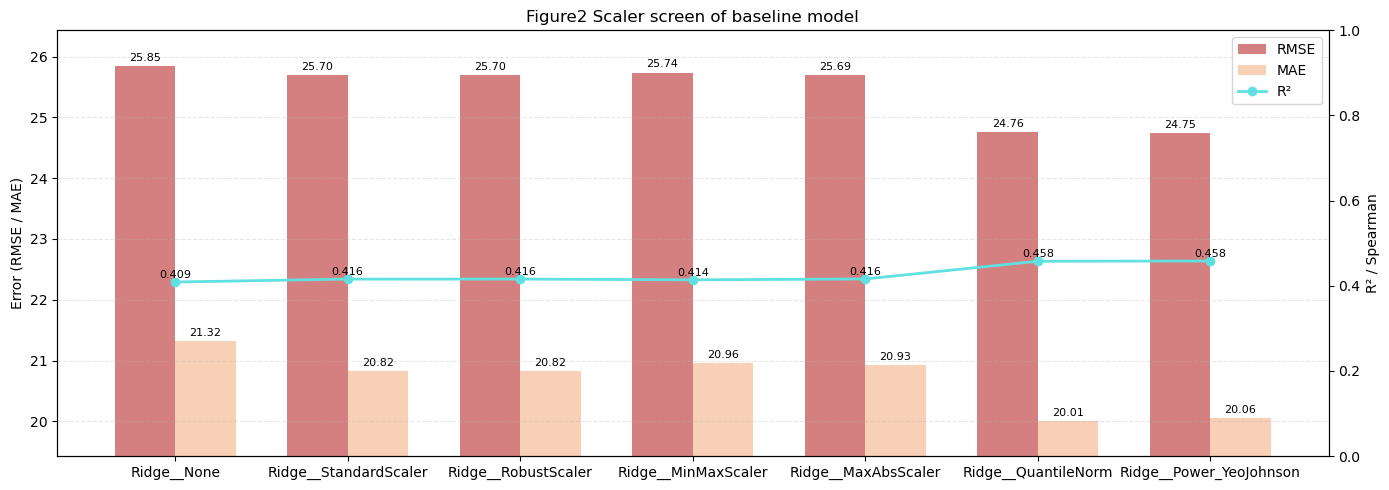

In [570]:
plot_bar(R1_screen,title="Figure2 Scaler screen of baseline model",
                   savepath="Figuredump/ScalerinitialPerformance.png",
                   xrotation=0,)

As shown in figure 2, the performance of the base line model (ridge regression) were evaluated with metrics including RMSE, MAE and the coefficient of determination($R^2$).  Among the combinations (no scaling, StandardScaler, RobustScaler, MinMaxScaler, and MaxAbsScaler, QuantileNorm and PowerTransformer) the overall RMSE showed some deviation where the values were in range of 25.85~24.75. With regards to the RMSE, the Power transformer (method = Yeojohnson) was the best performing scaler with $R^2$ of 0.458 followed by the QuantileNorm scaler with the same $R^2$. The remaining scalers showed inferior performance compared to the top 2 candidates.

Also, regarding the MAE values, the StandardScaler, RobustScaler recorded 20.82 which was superior to the No-scaler control; the MinMaxScaler, and MaxAbsScaler recorded 20.96 and the QuantileNorm and Power Transformer recorded 20.01. Considering all 3 metrics score, this improvement shown in the QuantileNorm and Power Transformer scalers suggest the transformation of the feature space into a guasssine distribution works best with the ridge regression model. 

However, it was concluded although some improvements were shown with the QuantileNorm and Power Transformer, the strong gaussian-like reshaping of the feature matrix does improve the performance of the model, the predictive capacity was somewhat sub optimal. Thus, at this point, it was speculated potentially he linear Ridge regression that assumes the linear relationship of the feature-lable and homogenous variance was not suitable for explaining our dataset. 


#### Crossvalidation

In [447]:
def run_cv_and_summary(model_dict, X, y, cv):

    def spearman_scorer(y_true, y_pred):
        return spearmanr(y_true, y_pred).correlation

    scoring = {
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "r2": "r2",
        "spearman": make_scorer(spearman_scorer),
    }

    cv_rows = []

    for name, model in model_dict.items():
        res = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            return_train_score=True
        )

        row = {
            "Model": name,
            "Test_RMSE": -res["test_rmse"].mean(),
            "Test_RMSE_std": -res["test_rmse"].std(),
            "Test_MAE": -res["test_mae"].mean(),
            "Test_MAE_std": -res["test_mae"].std(),
            "Test_R2": res["test_r2"].mean(),
            "Test_R2_std": res["test_r2"].std(),
            "Test_Spear": res["test_spearman"].mean(),
            "Test_Spear_std": res["test_spearman"].std(),
        }

        cv_rows.append(row)

    df = pd.DataFrame(cv_rows).set_index("Model")

    def pm(mean, std):          # for better readable results
        return f"{mean:.3f} ± {std:.3f}"

    pretty = pd.DataFrame({
        "Test_RMSE":     [pm(df.loc[m, "Test_RMSE"], df.loc[m, "Test_RMSE_std"]) for m in df.index],
        "Test_MAE":      [pm(df.loc[m, "Test_MAE"],  df.loc[m, "Test_MAE_std"])  for m in df.index],
        "Test_R2":       [pm(df.loc[m, "Test_R2"],   df.loc[m, "Test_R2_std"])   for m in df.index],
        "Test_Spearman": [pm(df.loc[m, "Test_Spear"],df.loc[m, "Test_Spear_std"])for m in df.index],
    }, index=df.index)

    return df, pretty


In [485]:
models_to_compare = {
    "Ridge__QuantileNorm_CV": Pipeline([
        ("sc", sc_dict["QuantileNorm"]),
        ("ridge", Ridge(alpha=1.0, max_iter=10000))]),
    "Ridge__Power_YeoJohnson_CV": Pipeline([
        ("sc", sc_dict["Power_YeoJohnson"]),
        ("ridge", Ridge(alpha=1.0, max_iter=10000))]),
}

R1_CV, pretty_df = run_cv_and_summary(models_to_compare, X_features, Y_Lable, cv)
R1_CV

,Test_RMSE,Test_RMSE_std,Test_MAE,Test_MAE_std,Test_R2,Test_R2_std,Test_Spear,Test_Spear_std
Model,,,,,,,,
Ridge__QuantileNorm_CV,25.129492,-0.667242,20.410305,-0.497233,0.430978,0.028083,0.668730,0.021530
Ridge__Power_YeoJohnson_CV,25.052178,-0.685390,20.307269,-0.497611,0.434464,0.028654,0.673359,0.020373


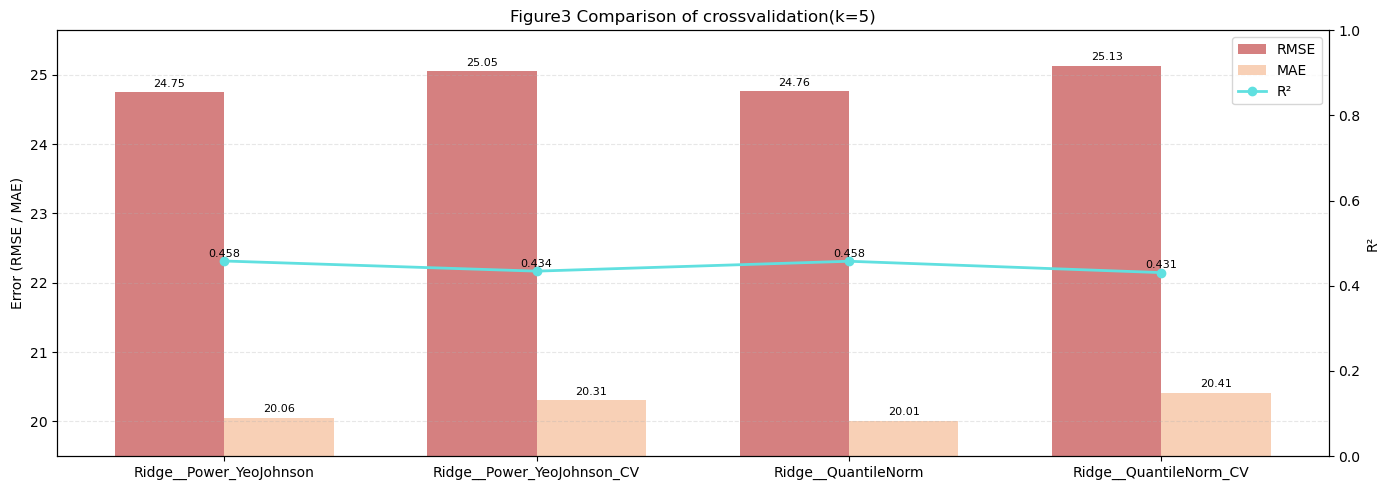

In [486]:
R1_screen_T = R1_screen.loc[["Ridge__Power_YeoJohnson","Ridge__QuantileNorm"]]
combined = pd.concat([R1_screen_T, R1_CV], axis=0).sort_index()

plot_bar(combined, title = "Figure3 Comparison of crossvalidation(k=5)",
         savepath="Figuredump/Figure 3 Crossvalidation results.png",xrotation=0,)

As shown in figure 3, both scalers after cross validation at K=5 yeilded improved performance with respect to the $R^2$ readings however, showed increased RMSE valeus. Although these readings were still outperforming the screened out scalers in the previous step, further hyperparameter tuning was likely required to obtain proper predictions. Since both scalers were performing essentialyl equally with the power transformer with a slightly lower RMSE, The Ridge + power transformer combination was chosen to be the base model.


#### Hyperparameter tune

In [488]:
# Final model
R1_final_model = Pipeline([("scaler", sc_dict["Power_YeoJohnson"]),
                        ("ridge", Ridge(alpha=1.0, max_iter=10000))])


In [384]:
def plot_learning_curve(
    model,
    X,
    y,
    cv,
    title="Learning curve",
    savepath=None,
    ax=None,
    show=True,
):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 8),
        cv=cv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        shuffle=True,
        random_state=42,
    )

    train_rmse_mean = -train_scores.mean(axis=1)
    train_rmse_std  =  train_scores.std(axis=1)
    val_rmse_mean   = -val_scores.mean(axis=1)
    val_rmse_std    =  val_scores.std(axis=1)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
        created_fig = True

    ax.plot(train_sizes, train_rmse_mean, "o-", label="Train RMSE")
    ax.fill_between(
        train_sizes,
        train_rmse_mean - train_rmse_std,
        train_rmse_mean + train_rmse_std,
        alpha=0.2,
    )
    ax.plot(train_sizes, val_rmse_mean, "o-", label="CV RMSE")
    ax.fill_between(
        train_sizes,
        val_rmse_mean - val_rmse_std,
        val_rmse_mean + val_rmse_std,
        alpha=0.2,
    )
    ax.set_xlabel("Number of training samples")
    ax.set_ylabel("RMSE")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend()

    if created_fig:
        plt.tight_layout()
        if savepath is not None:
            plt.savefig(savepath, dpi=300)
        if show:
            plt.show()

    return train_sizes, train_rmse_mean, val_rmse_mean
# # GPT was used aid the improve the function to accept arg for plot ax of this fucntion.

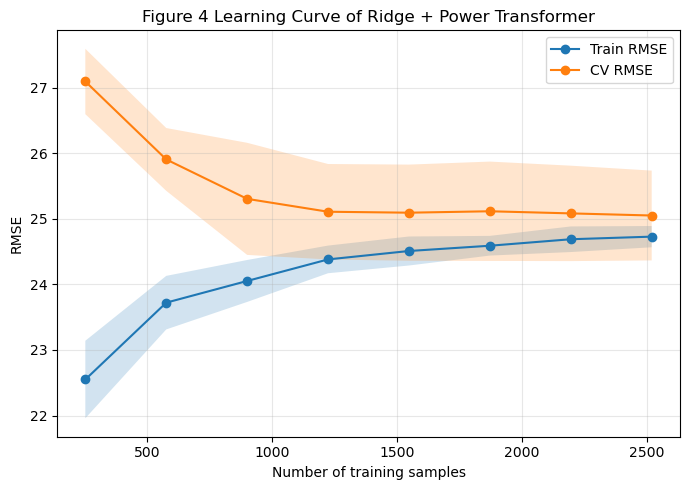

In [489]:
ts, tr_mean, val_mean = plot_learning_curve(
    R1_final_model,
    X_features,
    Y_Lable,
    cv=cv,
    title="Figure 4 Learning Curve of Ridge + Power Transformer",
    savepath="Figuredump/Figure 4LearningCurve_Ridge_PowerYJ.png"
)


As shown in Figure 4, it was interesting to see the plateauing of the train and CV RMSE at approximately sample size 1500. This demonstrates the fact that the regularisation is infact optimal for the model, thus increasing the size of the dataset will not yield better performance.
The train v CV RMSE exhibited a very small gap, suggesting the bias – variance trade off is good however, it is likely that further alpha regularisation will not yield improved performance. Thus, at this point agreeing with previous speculations, it was thought a more complex model(non-linear) was required to result better prediction performance. However, just to further confirmation I have proceed to the grid search to identify the best alpha for performance comparisons.


In [490]:
alphas = np.logspace(-4, 4, 100)     
#seting  search range 0.0001 ~ 10000; search interval = range/100

param_grid = {"ridge__alpha": alphas}

def tune_ridge(scaler, scaler_name):
    
    pipe = Pipeline([
        ("scaler", scaler),
        ("ridge", Ridge(max_iter=10000))
    ])
    
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        return_train_score=True,
    )

    gs.fit(X_tr, y_tr)

    print(f"\n=== Hyperparameter tuning: Ridge + {scaler_name} ===")
    print("Best alpha:", gs.best_params_["ridge__alpha"])
    print("Best CV RMSE:", -gs.best_score_)

    return gs


In [491]:
gs_powerYJ  = tune_ridge(sc_dict["Power_YeoJohnson"], "Power_YeoJohnson")

best_alpha_power = gs_powerYJ.best_params_["ridge__alpha"]

Final_Bench_model = Pipeline([
    ("scaler", sc_dict["Power_YeoJohnson"]),
    ("ridge", Ridge(alpha=best_alpha_power, max_iter=10000))
])

Bottom_Benchmark_Ridge_Power = eval_model(
    name=f"Ridge + PowerYJ (alpha={best_alpha_power:.3f})",
    md=Final_Bench_model,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te
)
bench_df =pd.DataFrame([Bottom_Benchmark_Ridge_Power])
bench_df



=== Hyperparameter tuning: Ridge + Power_YeoJohnson ===
Best alpha: 54.62277217684348
Best CV RMSE: 25.1340837495


,Model,Train_RMSE,Train_MAE,Train_R2,Train_Spearman,Test_RMSE,Test_MAE,Test_R2,Test_Spearman
0,Ridge + PowerYJ (alpha=54.623),24.829682,20.228381,0.444569,0.67903,24.761084,20.112423,0.457684,0.689364


In [499]:
models_to_compare = {"Ridge__Power_YeoJohnson_Tuned_CV": Pipeline([("sc", sc_dict["Power_YeoJohnson"]),
                    ("ridge", Ridge(alpha= 54.623, max_iter=10000))])}

bench_Tuned_CV, pt = run_cv_and_summary(models_to_compare, X_features, Y_Lable, cv)

In [528]:
bench_Tuned_CV
baseline = bench_Tuned_CV.rename(index={"Ridge__Power_YeoJohnson_Tuned_CV": "Baseline"})

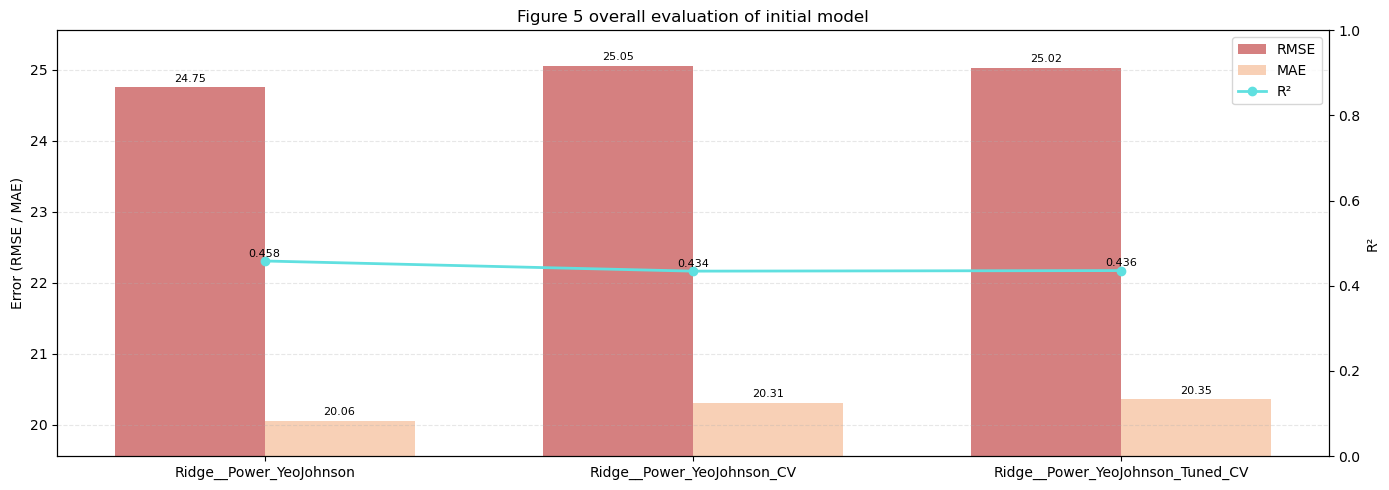

In [509]:
tt1 = combined.loc[["Ridge__Power_YeoJohnson","Ridge__Power_YeoJohnson_CV"]]
combined2 = pd.concat([tt1, bench_Tuned_CV], axis=0).sort_index()
plot_bar(combined2, title = "Figure 5 overall evaluation of initial model",
         savepath="Figuredump/Figure 5 overall evaluation.png",xrotation=0,)


To correctly compare the performance difference of the tuning, the gidsearched alpha(54.623) was crossvalidated as shown in figure 5. As expected the hyper parameter tuning did not yeild large differences. The RMSE decreased by 0.03 while the $R^2$ increased only by 0.002 suggesting the tuning resulted only marginal changes to the performance. It is speculated this is due to ridge regression model failing to capture the complex non-linear structure of the feature space which emphasises the need for a more complex model to truely predict and explain the data set. Thus, to compensate this inadiquacy, I have decided to to systematically compare different model families against different scalers as conducted previously.

# Model v Scaler sweep

In [251]:
# models
mdl_dict_linear = {"OLS": LinearRegression(),
                   "Lasso": Lasso(alpha=0.001, max_iter=10000),
                   "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)}
mdl_dict_nonlinear = {
    "RF": RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1,),
    "SVR_RBF": SVR(kernel="rbf",C=10.0,epsilon=0.1,),
    "KNN": KNeighborsRegressor(n_neighbors=10,)}

mdl_dict_all = {}
mdl_dict_all.update(mdl_dict_linear)
mdl_dict_all.update(mdl_dict_nonlinear)


In [252]:
rows = []

for sc_name, sc in sc_dict.items():
    for mdl_name, base_mdl in mdl_dict_all.items():

        if sc is None:
            pipe = Pipeline([
                ("model", base_mdl),
            ])
            name = f"{mdl_name}__NoScaler"
        else:
            pipe = Pipeline([
                ("scaler", sc),
                ("model", base_mdl),
            ])
            name = f"{mdl_name}__{sc_name}"

        res = eval_model(
            name,
            pipe,
            X_tr, y_tr,
            X_te, y_te
        )
        rows.append(res)

MvS_Sweep = pd.DataFrame(rows)
MvS_Sweep.set_index("Model", inplace=True)

MvS_Sweep_sorted = MvS_Sweep.sort_values("Test_RMSE")

MvS_Sweep_sorted.to_csv(
    os.path.join(log_dir, "model_scaler_comparison_ALL.csv")
)


q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.589e+03, tolerance: 2.797e+02
  model = cd_fast.enet_coordinate_descent(
q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e+04, tolerance: 2.797e+02
  model = cd_fast.enet_coordinate_descent(
q:\coding_dir\Coding_Programs\miniconda3\envs\QMULMLDL\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [424]:
MvS_Sweep_sorted.head(10).round(3)

,Train_RMSE,Train_MAE,Train_R2,Train_Spearman,Test_RMSE,Test_MAE,Test_R2,Test_Spearman
Model,,,,,,,,
SVR_RBF__MinMaxScaler,23.123,17.824,0.518,0.724,23.608,18.598,0.507,0.714
SVR_RBF__MaxAbsScaler,23.458,18.246,0.504,0.715,23.786,18.769,0.500,0.708
RF__QuantileNorm,9.122,7.296,0.925,0.973,23.967,19.287,0.492,0.698
RF__NoScaler,9.125,7.295,0.925,0.973,23.979,19.281,0.491,0.698
RF__MinMaxScaler,9.124,7.295,0.925,0.973,23.980,19.280,0.491,0.698
RF__MaxAbsScaler,9.124,7.294,0.925,0.973,23.984,19.282,0.491,0.698
RF__StandardScaler,9.126,7.296,0.925,0.973,23.984,19.284,0.491,0.698
RF__RobustScaler,9.126,7.295,0.925,0.973,23.984,19.284,0.491,0.698
RF__Power_YeoJohnson,9.124,7.293,0.925,0.973,23.987,19.281,0.491,0.698


These are the result of the initial model v scaler sweep. Regarding the models, here we have evaluated a panel of linear (OLS, Lasso, ElasticNet) and non-linear regressors (Random Forest, k-Nearest Neighbours, and [RBF-kernel support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)). 

In agreement with the inital speculations, across all model–scaler combinations the top 5 performance model were observed as either the SVR_RFB or Random Forest (RF) which are both non-linear models. The Test RMSE were in range of 23.61~23.98 where the top 2 candidates were both the SVR_RBF. In agreement to the RMSE scoreing, the $R^2$ results were consistently outperformed by the SVR models scoring 0.51/0.50 compared to the 0.49 by the RF models. Interestingly the MinMax scaler seemed to be performing best for the SVR, while the performance was limited in the RF + MinMax combination scoring 23.98 and 0.49 for RMSE and $R^2$ scores each respectively.

Interestingly, with regards to the test performance observed for the RF models, the train scores were exceptionally good scoring around 9.12(RMSE) and 0.925($R^2$) suggesting high degree of overfitting. On the conterary, the RBF-SVR + MinMax scaling recorded a train /TEST RMSE of 23.12/23.61 and $R^2$ 0.52/0.51 suggesting a better bias – variance trade off. 
For the case of the linear models, the performance were generally similar, and consistently performing best with the Quantile normalisation or Power Transformer for scalers. Interestingly, for the case of the Lasso and ElasticNet models, no evidence of clear advantage were observed, likely because many of the sequence-based biophysical features are highly correlated.

Finally for the case of the K-nearest neighbours resulted RMSE in the range of 27.5–28.7 and R^2dropping to 0.27–0.33 even with appropriate scaling. These results were some what expected as the biological data that are highly constrained on the aminoacid biophysical properties causing dimensionality/multicollinearity issues causing the physical distance between the sample to become less informative while the local averaging fails to resemble the global relationship resulting poor generalisation and underfitting.
As a result, it was concluded the combination of RBF-SVR + MinMax provides the best performance while the RF models are still in competition but slightly inferior. Also although slightly lower, the initial baseline(Ridge + Power Transformer) exhibited strong performance, potentially placing it self as an alternative model that can be utilised in situations where computational cost and explainability – precision trade off are important. Thus for furtehr validation of the model, SVR_RBF__MinMaxScaler and RandomForest__QuantileNorm were selected for cross validation.

In summary, the top 3 models all achived a significantly reduced RMSE and significant increase in the $R^2$ compared to the baseline model. Thus, the two combinations SVR_RBF + MinMaxScaler and RF + QuantileNorm were proceeded for further cross validation.


### Cross Validation

In [546]:
Final_candidate_models = {"SVR_RBF__CV":
                          Pipeline([("scaler", MinMaxScaler()),("model", SVR(kernel="rbf"))]),
                          "RF_CV":
                          Pipeline([("scaler", QuantileTransformer(output_distribution="normal", random_state=42)),("model", RandomForestRegressor(random_state=42))])}
round2_CV, pretty_df = run_cv_and_summary(Final_candidate_models, X_features, Y_Lable, cv)

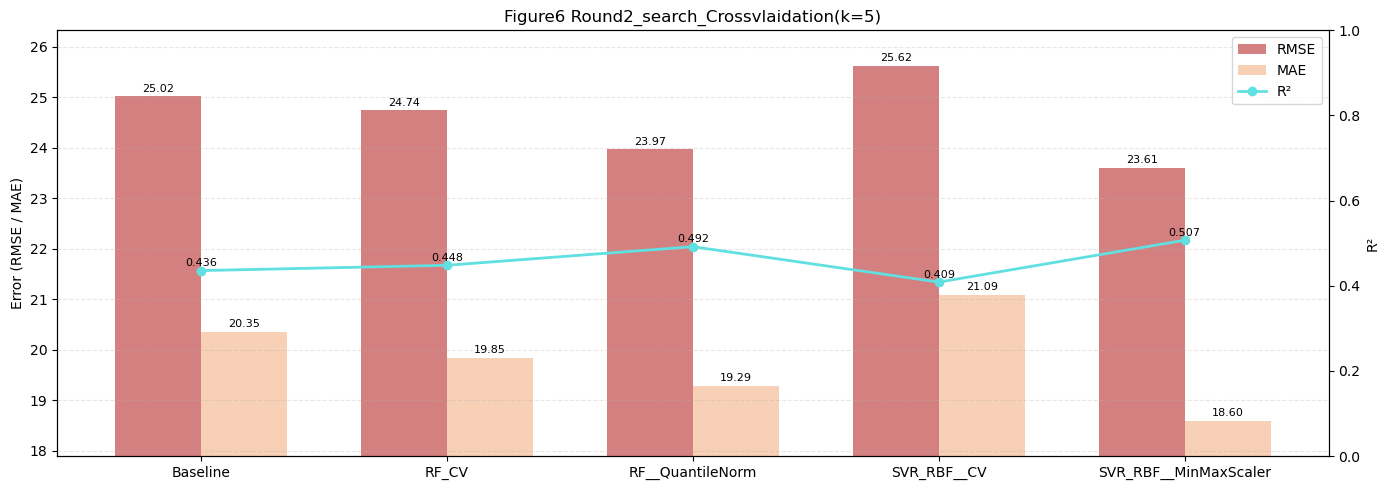

In [547]:
topp = MvS_Sweep_sorted.loc[["SVR_RBF__MinMaxScaler","RF__QuantileNorm"]]

combined3 = pd.concat([baseline, topp, round2_CV], axis=0).sort_index()

plot_bar(combined3, title = "Figure6 Round2_search_Crossvlaidation(k=5)",
         savepath="Figuredump/Figure6 Round2_search_Crossvlaidation",xrotation=0,)

As shown in figure 6, after cross validation, both models exhibited increased RMSE values(23.61 -> 25.62 / 23->24.74) and reduced $R^2$ values(0.492 -> 0.448 / 0.5->0.409). interestingly, the decrease in $R^2$ was significant, for the case of the SVR model, scoring 0.409 after the cross validation. This significant decrease exhibited reduced $R^2$ performance compared to the baseline model, while for the case of the RF, although significantly reduced, was outperforming the baseline model. At this point, due to the significant changes in performace post crossvalidation, it was difficult to select a signle model for further evaluation, and it was speculated there were space for improvement for both models due to un-tuned hyperparameters. 
# Hyper parameter Tuning 

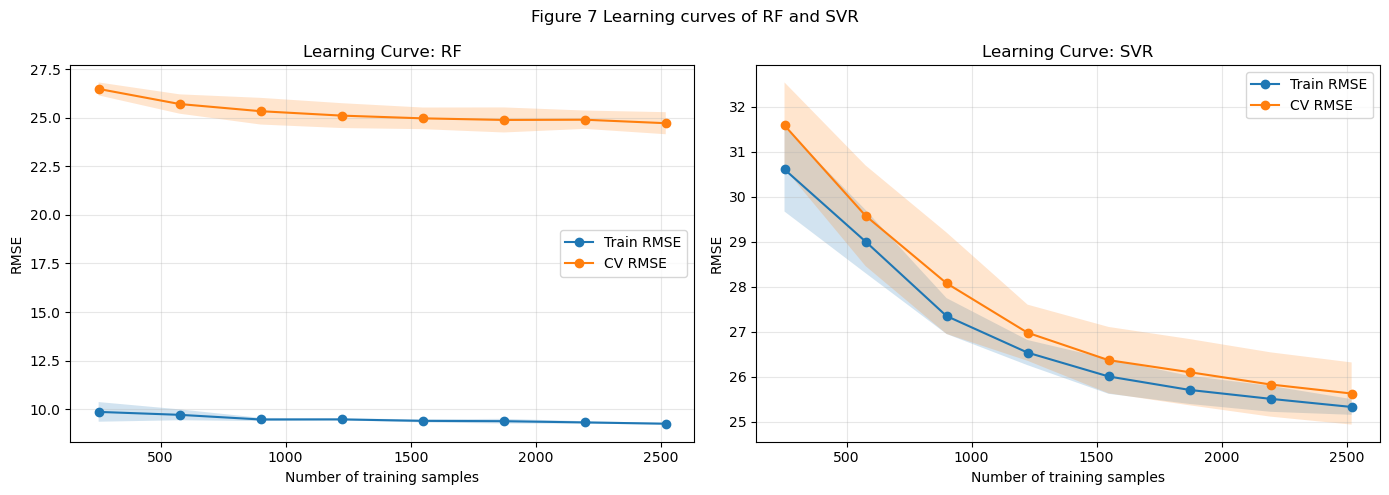

In [338]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


ts_rf, tr_rf, val_rf = plot_learning_curve(
    Final_candidate_models["RF__QuantileNorm"],
    X_features,
    Y_Lable,
    cv,
    title="Learning Curve: RF",
    ax=axes[0])

ts_svr, tr_svr, val_svr = plot_learning_curve(
    Final_candidate_models["SVR_RBF__MinMaxScaler"],
    X_features,
    Y_Lable,
    cv,
    title="Learning Curve: SVR",
    ax=axes[1])
plt.suptitle("Figure 7 Learning curves of RF and SVR")
plt.tight_layout()
plt.savefig("Figuredump/Figure_RF_SVR_learning_curves.png", dpi=300)
plt.show()


As expected, as shown in figure 7, both models require hyperparameter tuning however, it is clear that the learning curves indicate that they need adjustments in different directions. For the case of the RF model, the tarin RMSE remains around 10~5 suggesting there is low bias while the CV RMSE is not reducing with increased sample size. This suggest there are significant over fitting to the train data. currently the RF regressor is set to 100 trees, max_depth =None(unlimited) min_samples_leaf=1, max_features=1.0 which corresponds to a relatively high-capacity ensemble and is prone to overfitting.

For the case of the SVR_RBF, both train and CV starts high and reduces over sample size platauing at around 25.5. This suggests the variance is not large with poetnatial underfitting. Regarding currently the SVR_RFB is set to default parameters C=1, epsilon=0.1, gamma="scale" with kernal set to RFB, it is speculated further fitting is requried through reduced epsilon to increase sample effect to the loss. However, since I lack deep understanding of these models, we will be trying out various ranges of parameter for tuning.

In [ ]:
svr_param_grid = {
    "model__C": [1, 10, 30, 100],
    "model__gamma": ["scale", 0.1, 0.01, 0.001],
    "model__epsilon": [0.1,0.05,0.01],}

rf_param_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [5, 10, 20],
    "model__max_features": ["sqrt", 0.3, 0.5],
    "model__min_samples_leaf": [3, 5, 10],}

In [ ]:
svr_base = Final_candidate_models["SVR_RBF__MinMaxScaler"]

gs_svr = GridSearchCV(
    estimator=svr_base,
    param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

gs_svr.fit(X_features, Y_Lable)

print("SVR_RBF__MinMaxScaler GridSearch")
print("Best params:", gs_svr.best_params_)
print("Best CV RMSE:", -gs_svr.best_score_)


rf_base = Final_candidate_models["RF__QuantileNorm"]

gs_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

gs_rf.fit(X_features, Y_Lable)
print()
print("RandomForest__QuantileNorm GridSearch")
print("Best params:", gs_rf.best_params_)
print("Best CV RMSE:", -gs_rf.best_score_)


SVR_RBF__MinMaxScaler GridSearch
Best params: {'model__C': 30, 'model__epsilon': 0.1, 'model__gamma': 'scale'}
Best CV RMSE: 24.211697908690812

RandomForest__QuantileNorm GridSearch
Best params: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}
Best CV RMSE: 24.526434348791447


In [552]:
best_svr = gs_svr.best_estimator_
best_rf  = gs_rf.best_estimator_

SVR_Best_params = {'model__C': 30, 'model__epsilon': 0.1, 'model__gamma': 'scale'}
RF_Best_params = {'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 3, 'model__n_estimators': 500}
# saved in case Kernal boom

res_svr = eval_model(
    name="SVR_RBF_Tuned",
    md=best_svr,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te,
)

res_rf = eval_model(
    name="RF_Tuned",
    md=best_rf,
    X_tr=X_tr, y_tr=y_tr,
    X_te=X_te, y_te=y_te,
)

final_tuned_df = pd.DataFrame([res_svr, res_rf]).set_index("Model")

In [579]:
R2Tuned_model = {"SVR_RBF_Tuned_CV": best_svr,
                 "RF_Tuned_CV":      best_rf,}

round3_CV, pretty_df = run_cv_and_summary(R2Tuned_model,X_features,Y_Lable,cv)


In [581]:
round3_CV

,Test_RMSE,Test_RMSE_std,Test_MAE,Test_MAE_std,Test_R2,Test_R2_std,Test_Spear,Test_Spear_std
Model,,,,,,,,
SVR_RBF_Tuned_CV,24.211698,-0.719342,19.035124,-0.437286,0.471656,0.030444,0.695346,0.018641
RF_Tuned_CV,24.526434,-0.579018,19.712300,-0.392460,0.457959,0.025039,0.674306,0.019491


In [564]:
combined5 = pd.concat([combined3, final_tuned_df,round3_CV], axis=0).sort_index()
ss = combined5.loc[["Baseline", "SVR_RBF__CV", "SVR_RBF_Tuned_CV"]]
ss1 = combined5.loc[["Baseline", "RF_CV", "RF_Tuned_CV" ]]
ss2 = combined5.loc[["Baseline", "SVR_RBF_Tuned_CV", "RF_Tuned_CV" ]]

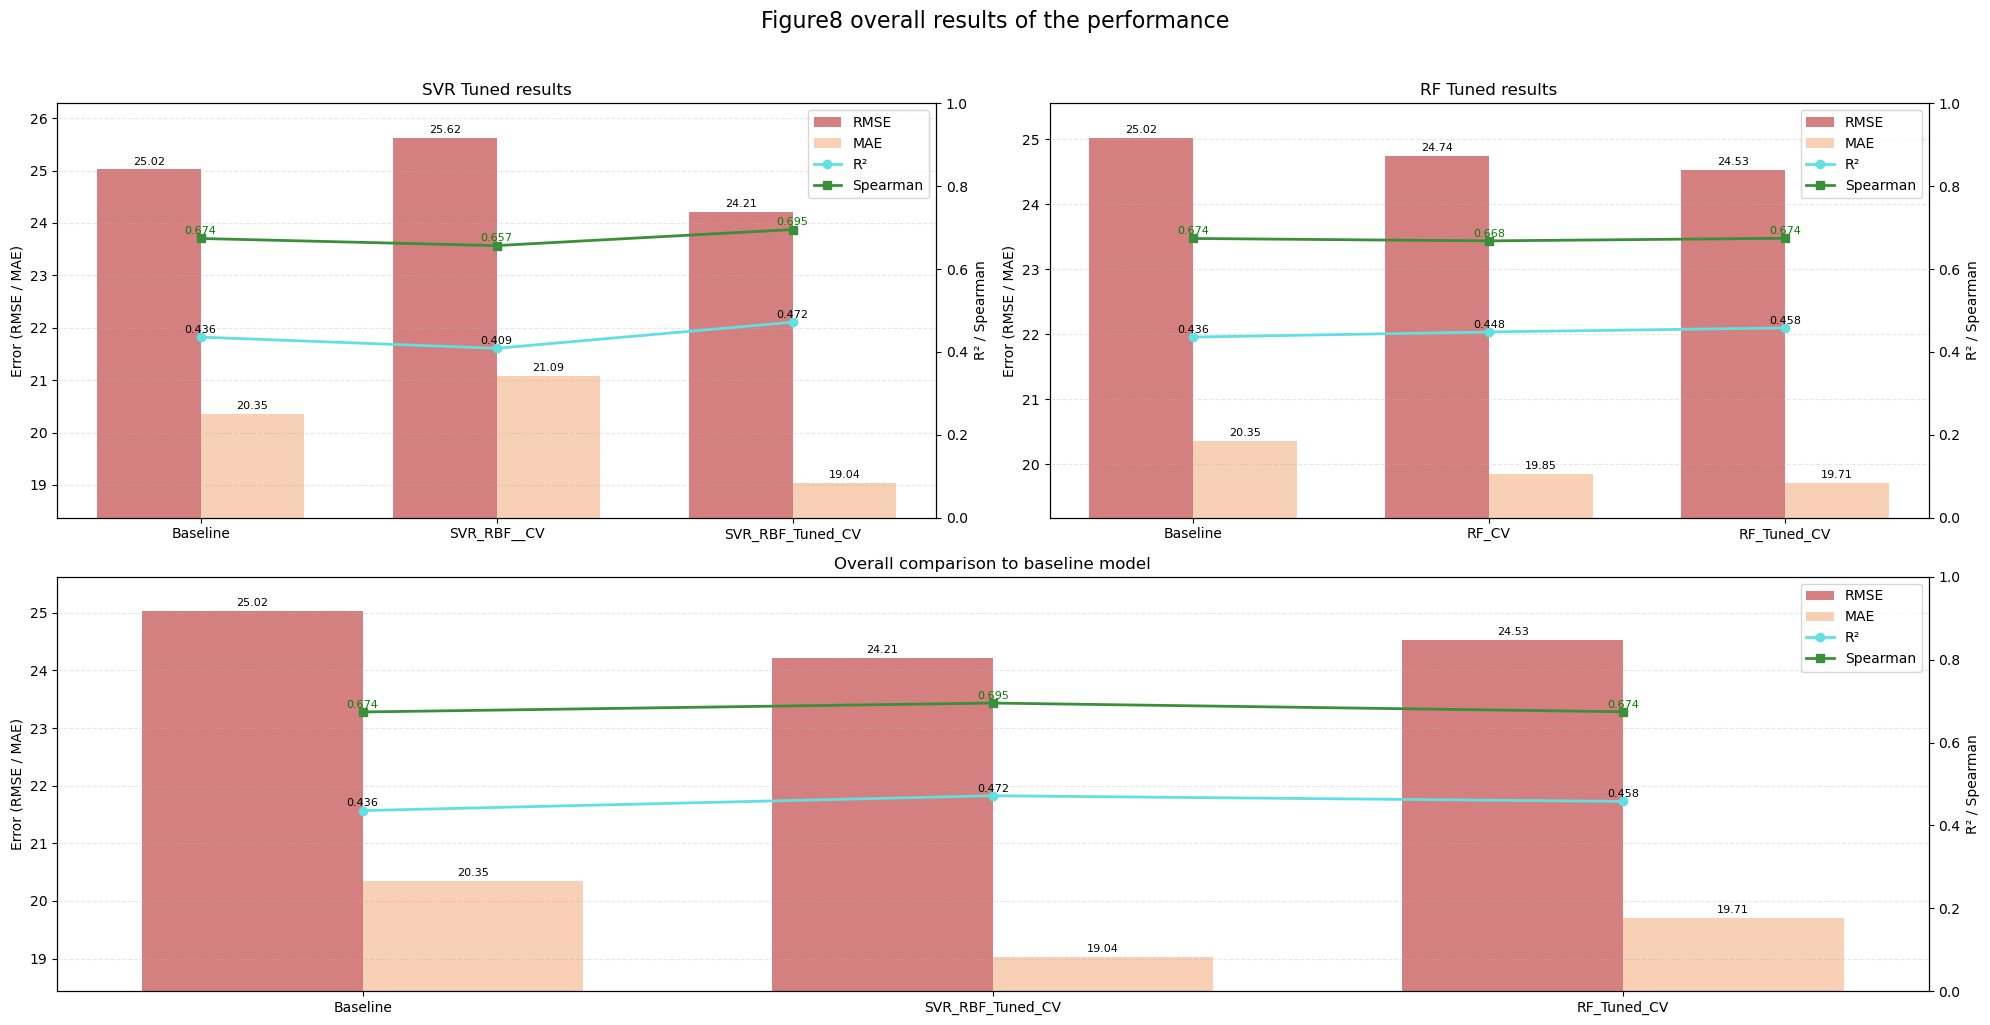

In [577]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

bot  = fig.add_subplot(gs[1, :])
ax_top1 = fig.add_subplot(gs[0, 0])
ax_top2 = fig.add_subplot(gs[0, 1])

plot_bar(ss,
         title="SVR Tuned results",
         xrotation=0,
         ax=ax_top1,
         include_spearman=True)

plot_bar(ss1,
         title="RF Tuned results",
         xrotation=0,
         ax=ax_top2,
         include_spearman=True)

plot_bar(ss2,
         title="Overall comparison to baseline model",
         xrotation=0,
         ax=bot,
         include_spearman=True)
fig.suptitle("Figure8 overall results of the performance", fontsize=16, y=1.02)
fig.tight_layout()
fig.savefig("Figuredump/Figure8_Tuned_results.png", dpi=500)
plt.show()

# Conclusion and Discussion

Across all models evaluatd in this study, only modest performance improvemnts were observed with respect to the baseline model(lindear Ridge regression). Even with sufficient grid search with C = [1, 10, 30, 100], "model__gamma": ["scale", 0.1, 0.01, 0.001] for the Support vector regression and estimators = [200, 500], max_depth = [5, 10, 20], max_features = ["sqrt", 0.3, 0.5] min_samples_leaf = [3, 5, 10] for the Random Tree regressor, both the tuned non-linear models exhibited an RMSE of 24.21(std 0.719) and 24.53(0.579) each respectively. This indicated the difference in RMSE values were not significantly different to that of the baseline linear Ridge regression model. Similarly, the recorded %R^2% and the spearman values for the tuned models exhibited also no significant increase comared to the baseline model suggesting both the selected linear and non-linear models faield to properly generalise the dataset with inadiquate test performance. However, from the tuning a significant reduction in RMSE and increase in $R^2$ was observed for the case of the SVR model, suggesting for the case of the RF model, the underperformance was driven less by suboptimal hyperparameters and more by intrinsic constraints of the dataset and engineered features. Also after  reviewing the results for all the models analysed during this project, the relatively small difference in the test and tarin set error suggest, all models tested were overfitting the train set. As shown in the learning curve, it is speculated with increased volume of data the SVR model has space for performance improvement, but the extent of improvemnt is yet unclear at this point.

Regarding the data set it self, as the main features extracted from the original data set only includes several features, which are by definition highly correlated to each other due to physical laws, even with the sequence based feature engineering, the physiochemcial and biophysical propereties may have not sufficiently encode or translate a higher-order structural information regarding solubility. As shown in various industrial processes, the concept of protein solubility and aggregation propensity are often delt in a more rough manner in a sense that during preclincial screening phase of drug development, instead of precision assays a generalised pipeline approach are often taken due to the small deviation in global structure of biologics. Also, as mentioned previously, ESOL like data sets, or biological datasets in general include an extremely high degree of noise.

Moreover, as shown in figure 1, the class imbalance along the solubility spectrom may be playing a key part to the under performance of the models tested. The initial statistical analyis of the dimension demonstrated the dimension data distribution to be in a non-guassian or normal distribution like shpae. However, for the case of the RF model, the Quantile Transformer was adopted as the best performing combination in the inital sweep. This scaler is effective for cases when the selected algorithm assumes a guassian like dimension distribution, for our case, this scaling likely reduced or elemenated the natural extreme-end tail properties of the diemsnion which in turn reduced the information gained at the extreme boundaries. Thus,for the case of the RF model it is specualted the signfiicant overfitting observed was casued or atleast heavily facilitated by this mapping of datapoints to a guassin like shape. 

Overall, the results suggest that further performance analysis should be conducted using models that can robustly predict in skewed feature distribution and non-uniform data desnity. Since our chosen dataset exhibits heavly tailed variables and extreme values, the Guassian Process Regression(GPR) or gradient boosted tree ensemble(GBTe)s may be a suitable candidate since the models perform well agianst unsclaled data sets. Also, although due to time constraints, the effect of dimensionality reduction during pre-processing was not explored during this project. However, after reviewing the results, this seems a promising direction for further evalaution and to adress the high correlation between the dimensions. As certain features in the processed dataset inlcuding hydrophobic fraction v GRAVY and Positive Charge v Net charge may be causing learning in a unnecessary projection, reducing the features to an orthogonal priccnipal componant may be a prospective next stage analysis.

Currently there are tools in the market inlcuding Protein-Sol, CamSol and DeepSol which tackels the idea of solubility prediction. However, yet these models are largely limited to E.Coli recombinatn expression proteins which greatly limits the practical use in drug discovery pipelines. Moreover, these computational tools focus on the bianary classification of solubility or aggreegation propensity instead of a continouse solublity prediction. Depending on the threshold setting, it is belived the models explored in this project may also be considered optimal. however, this type of prediction greatly limits the information that can be gained and utilised. 





![alt text](Figuredump/stasts.png)